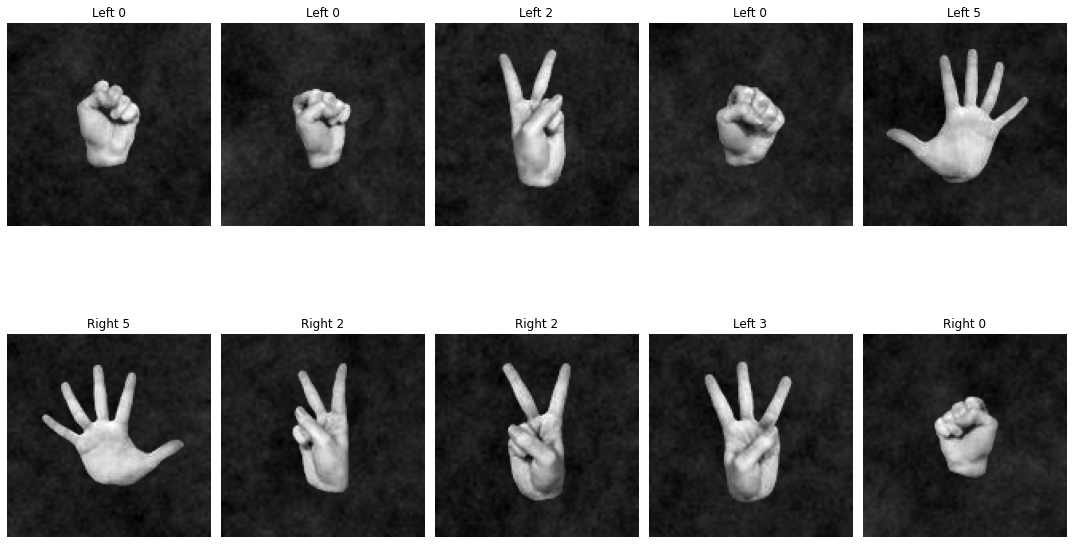

In [32]:
import os
from PIL import Image
import matplotlib.pyplot  as plt

def visua_img(file_path,n=10):
    
    img_list=os.listdir(file_path)
    fig,ax=plt.subplots(n//5,5,figsize=(15,10))
    
    for i,img_name in enumerate(img_list[:n]):
        img= Image.open(file_path+img_name)
        n_label=img_name[-6]
        hand_label=img_name[-5]
        ax[i//5][i%5].imshow(img,cmap='gray')
        ax[i//5][i%5].axis('off')
        ax[i//5][i%5].set_title('{} {}'.format( 'Left' if hand_label=='L' else 'Right',n_label))
    plt.tight_layout()
    plt.show()
visua_img('./train/',10)

In [1]:
import torch
torch.cuda.empty_cache()

In [17]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot  as plt

from torch import nn

seed = torch.initial_seed()

train_batch_size = 40  # Define train batch size
test_batch_size = 120  # Define test batch size (can be larger than train batch size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)



# define class to build dataset
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self,file_path,transform):
        self.file_path=file_path
        self.transform=transform
        self.image_list= os.listdir(file_path)       # list of image names
        random.shuffle(self.image_list)
        
    def __getitem__(self, idx):

        image_name = self.image_list[idx]

        data, label = Image.open(self.file_path+image_name), image_name[-6:-4]     
        label =  int(label[0]) + 6*(label[1]=='R')

        return self.transform(data).to(device), torch.tensor(label).to(device)
    
    def __len__(self):
        return len(self.image_list)
    
trf = T.Compose([T.ToTensor(), 
             T.Normalize((0.5,),(0.5,))])
train_dataset=BuildDataset('./train/',trf)
test_dataset=BuildDataset('./test/',trf)


cuda:0


In [18]:

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=True,
)

len_train=len(train_loader)
len_val=len(test_loader)
print(len_train)
print(len_val)

#count=0
#fig,ax=plt.subplots(1,5,figsize=(15,10))
#for i,j in train_loader:
#    img=i[count].squeeze(0)
#    print(img.shape)
#    ax[count].imshow(img.to('cpu').numpy())
#    print(j[count])
#    if count==4:
#        break
#    count+=1

450
30


In [19]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=12):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=11, stride=3, padding=0, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=5, stride=1, padding=2,bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=192, out_channels=72, kernel_size=2, stride=2, padding=0),
            nn.ReLU(inplace=True),
        )
        self.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5*5*72, 3*6*30),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
            nn.Linear(3*6*30, 3*4*8),
            nn.ReLU(inplace=True),
            
            nn.Linear(3*4*8,num_classes),
        )
        self.classifier=nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv(x)
        
        # reduce the dimensions for linear layer input
        out = out.view(out.size(0), 5*5*72)       
        
        out = self.fc(out)
        
        prob = self.classifier(out)
        return prob

In [20]:
import numpy as np
import tqdm

# initialize the number of classes for output
model = AlexNet(12)
model.to(device)

# define RMSProp optimizer with learning rate 0.0002
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00002,weight_decay=1e-6)

epochs = 8

loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# every 90 iterations for log
log_interval = 90

loss_list = []
iteration_list = []
accuracy_list = []
count = 0

if __name__ =='__main__':
    for epoch in tqdm.trange(epochs):
        for idx, (data, labels) in enumerate(train_loader):
    
            # Calculate training loss on model
            pred_y = model(data)
            loss = loss_fn(pred_y, labels)
            # zeros gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            # save loss and accuracy for every 25 iterations
            if idx % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        epoch + 1,
                        idx * train_batch_size,
                        len_train*train_batch_size,
                        100.0 * idx / len_train,
                        loss.item(),
                    )
                )
                loss_list.append(loss.item())
                count += log_interval
                iteration_list.append(count)
                
                # calculate validation accuracy
                with torch.no_grad():
                    n_sample = len_val*test_batch_size
                    n_correct = 0
                    for idxx, (data, labels) in enumerate(test_loader):
                        #data=data.to(device)
                        #labels=labels.to(device)
                        pred_y = model(data).to('cpu')
                        labels=labels.to('cpu')
                        n_correct += sum(
                            (torch.argmax(pred_y, dim=1) == labels).type(torch.FloatTensor)
                        )
                    accuracy_list.append(100.0 * n_correct / n_sample)
                    print(
                        "Validation set: number of correct labels: {}/{} accuracy: ({:.0f}%)\n".format(
                            int(n_correct), n_sample, 100.0 * n_correct / n_sample
                        )
                    )

  0%|                                                                                             | 0/8 [00:00<?, ?it/s]

Train Epoch: 1 [0/18000 (0%)]	Loss: 2.483760
Validation set: number of correct labels: 308/3600 accuracy: (9%)

Train Epoch: 1 [3600/18000 (20%)]	Loss: 2.280026
Validation set: number of correct labels: 1594/3600 accuracy: (44%)

Train Epoch: 1 [7200/18000 (40%)]	Loss: 2.113071
Validation set: number of correct labels: 2331/3600 accuracy: (65%)

Train Epoch: 1 [10800/18000 (60%)]	Loss: 1.972980
Validation set: number of correct labels: 2770/3600 accuracy: (77%)

Train Epoch: 1 [14400/18000 (80%)]	Loss: 1.764549
Validation set: number of correct labels: 2879/3600 accuracy: (80%)



 12%|██████████▌                                                                         | 1/8 [05:07<35:55, 307.91s/it]

Train Epoch: 2 [0/18000 (0%)]	Loss: 1.791149
Validation set: number of correct labels: 3088/3600 accuracy: (86%)

Train Epoch: 2 [3600/18000 (20%)]	Loss: 1.798261
Validation set: number of correct labels: 3091/3600 accuracy: (86%)

Train Epoch: 2 [7200/18000 (40%)]	Loss: 1.746802
Validation set: number of correct labels: 3216/3600 accuracy: (89%)

Train Epoch: 2 [10800/18000 (60%)]	Loss: 1.754350
Validation set: number of correct labels: 3207/3600 accuracy: (89%)

Train Epoch: 2 [14400/18000 (80%)]	Loss: 1.746870
Validation set: number of correct labels: 3294/3600 accuracy: (92%)



 25%|█████████████████████                                                               | 2/8 [09:56<29:40, 296.73s/it]

Train Epoch: 3 [0/18000 (0%)]	Loss: 1.745340
Validation set: number of correct labels: 3315/3600 accuracy: (92%)

Train Epoch: 3 [3600/18000 (20%)]	Loss: 1.693236
Validation set: number of correct labels: 3309/3600 accuracy: (92%)

Train Epoch: 3 [7200/18000 (40%)]	Loss: 1.672199
Validation set: number of correct labels: 3355/3600 accuracy: (93%)

Train Epoch: 3 [10800/18000 (60%)]	Loss: 1.738767
Validation set: number of correct labels: 3370/3600 accuracy: (94%)

Train Epoch: 3 [14400/18000 (80%)]	Loss: 1.620253
Validation set: number of correct labels: 3396/3600 accuracy: (94%)



 38%|███████████████████████████████▌                                                    | 3/8 [14:45<24:26, 293.23s/it]

Train Epoch: 4 [0/18000 (0%)]	Loss: 1.686337
Validation set: number of correct labels: 3421/3600 accuracy: (95%)

Train Epoch: 4 [3600/18000 (20%)]	Loss: 1.643438
Validation set: number of correct labels: 3434/3600 accuracy: (95%)

Train Epoch: 4 [7200/18000 (40%)]	Loss: 1.634412
Validation set: number of correct labels: 3438/3600 accuracy: (96%)

Train Epoch: 4 [10800/18000 (60%)]	Loss: 1.625821
Validation set: number of correct labels: 3447/3600 accuracy: (96%)

Train Epoch: 4 [14400/18000 (80%)]	Loss: 1.626898
Validation set: number of correct labels: 3469/3600 accuracy: (96%)



 50%|██████████████████████████████████████████                                          | 4/8 [19:42<19:37, 294.37s/it]

Train Epoch: 5 [0/18000 (0%)]	Loss: 1.619845
Validation set: number of correct labels: 3474/3600 accuracy: (96%)

Train Epoch: 5 [3600/18000 (20%)]	Loss: 1.635327
Validation set: number of correct labels: 3477/3600 accuracy: (97%)

Train Epoch: 5 [7200/18000 (40%)]	Loss: 1.632602
Validation set: number of correct labels: 3487/3600 accuracy: (97%)

Train Epoch: 5 [10800/18000 (60%)]	Loss: 1.668948
Validation set: number of correct labels: 3500/3600 accuracy: (97%)

Train Epoch: 5 [14400/18000 (80%)]	Loss: 1.624417
Validation set: number of correct labels: 3497/3600 accuracy: (97%)



 62%|████████████████████████████████████████████████████▌                               | 5/8 [24:09<14:14, 284.84s/it]

Train Epoch: 6 [0/18000 (0%)]	Loss: 1.663925
Validation set: number of correct labels: 3511/3600 accuracy: (98%)

Train Epoch: 6 [3600/18000 (20%)]	Loss: 1.647682
Validation set: number of correct labels: 3520/3600 accuracy: (98%)

Train Epoch: 6 [7200/18000 (40%)]	Loss: 1.640101
Validation set: number of correct labels: 3523/3600 accuracy: (98%)

Train Epoch: 6 [10800/18000 (60%)]	Loss: 1.682767
Validation set: number of correct labels: 3537/3600 accuracy: (98%)

Train Epoch: 6 [14400/18000 (80%)]	Loss: 1.623452
Validation set: number of correct labels: 3539/3600 accuracy: (98%)



 75%|███████████████████████████████████████████████████████████████                     | 6/8 [27:19<08:24, 252.30s/it]

Train Epoch: 7 [0/18000 (0%)]	Loss: 1.631829
Validation set: number of correct labels: 3528/3600 accuracy: (98%)

Train Epoch: 7 [3600/18000 (20%)]	Loss: 1.619398
Validation set: number of correct labels: 3538/3600 accuracy: (98%)

Train Epoch: 7 [7200/18000 (40%)]	Loss: 1.618836
Validation set: number of correct labels: 3544/3600 accuracy: (98%)

Train Epoch: 7 [10800/18000 (60%)]	Loss: 1.618864
Validation set: number of correct labels: 3542/3600 accuracy: (98%)

Train Epoch: 7 [14400/18000 (80%)]	Loss: 1.620332
Validation set: number of correct labels: 3550/3600 accuracy: (99%)



 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [30:23<03:50, 230.06s/it]

Train Epoch: 8 [0/18000 (0%)]	Loss: 1.619087
Validation set: number of correct labels: 3545/3600 accuracy: (98%)

Train Epoch: 8 [3600/18000 (20%)]	Loss: 1.618848
Validation set: number of correct labels: 3544/3600 accuracy: (98%)

Train Epoch: 8 [7200/18000 (40%)]	Loss: 1.629149
Validation set: number of correct labels: 3556/3600 accuracy: (99%)

Train Epoch: 8 [10800/18000 (60%)]	Loss: 1.648542
Validation set: number of correct labels: 3535/3600 accuracy: (98%)

Train Epoch: 8 [14400/18000 (80%)]	Loss: 1.619070
Validation set: number of correct labels: 3549/3600 accuracy: (99%)



100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [33:31<00:00, 251.40s/it]


# Loss Curve and Accuracy Curve

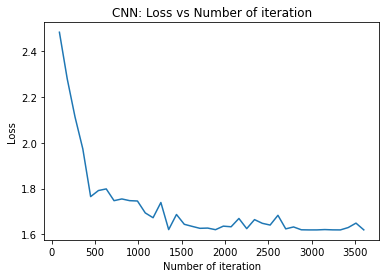

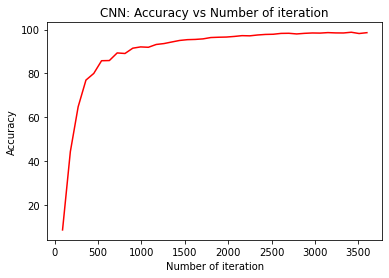

In [28]:
import matplotlib.pyplot as plt

# visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

# Prediction on first n images

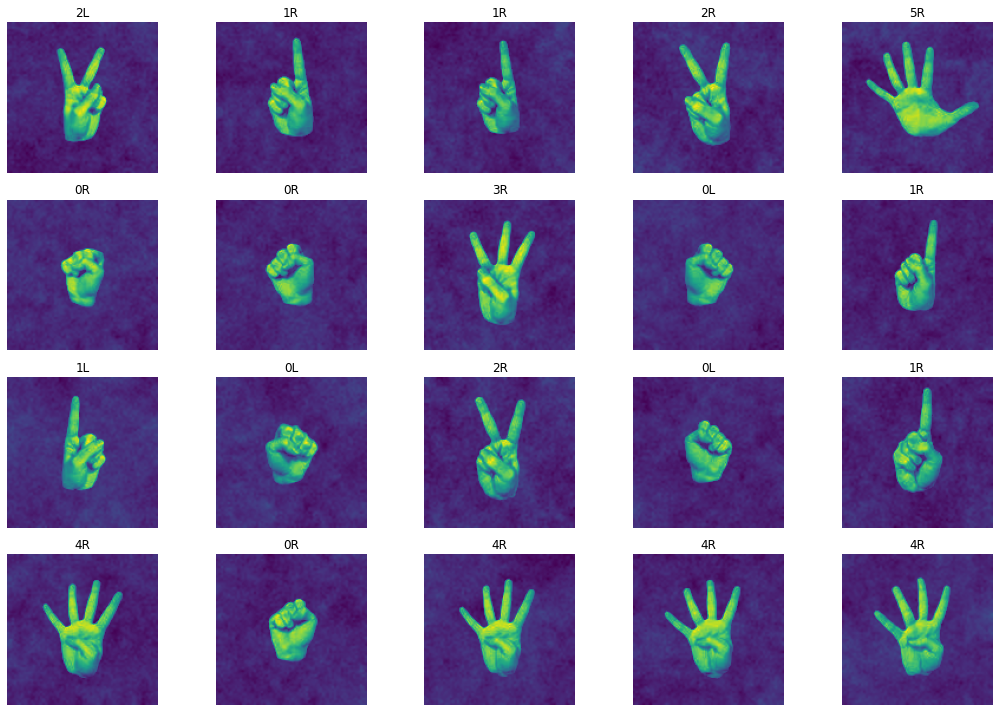

In [23]:
def get_prediction(file_path, num, transform):
    
    imgs = os.listdir(file_path)
    random.shuffle(imgs)
    imgs=imgs[:num]
    imgs=[Image.open(file_path+i) for i in imgs]


    inp = list(map(lambda x: transform(x) , imgs))
    inp = torch.stack(inp,dim=0)
    inp=inp.to(device)    
    pred= model(inp).to('cpu')
    
    def label_pred(pred):
        l=torch.argmax(pred).item()
        
        return str(l%6)+('L' if l<=5 else 'R')
        
    pred= [label_pred(i) for i in pred]
    
    fig,ax = plt.subplots(num//5,5,figsize=(15,10))
    for idx,image in enumerate(imgs):
        img=imgs[idx]
        ax[idx//5][idx%5].axis('off')
        ax[idx//5][idx%5].imshow(img)
        ax[idx//5][idx%5].set_title(pred[idx])
    plt.tight_layout()
    plt.show()
        
    pass
        
n_pred=20

get_prediction('./test/',n_pred, trf)

# Visualization on feature map

Total convolution layers: 5


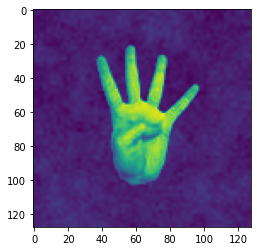

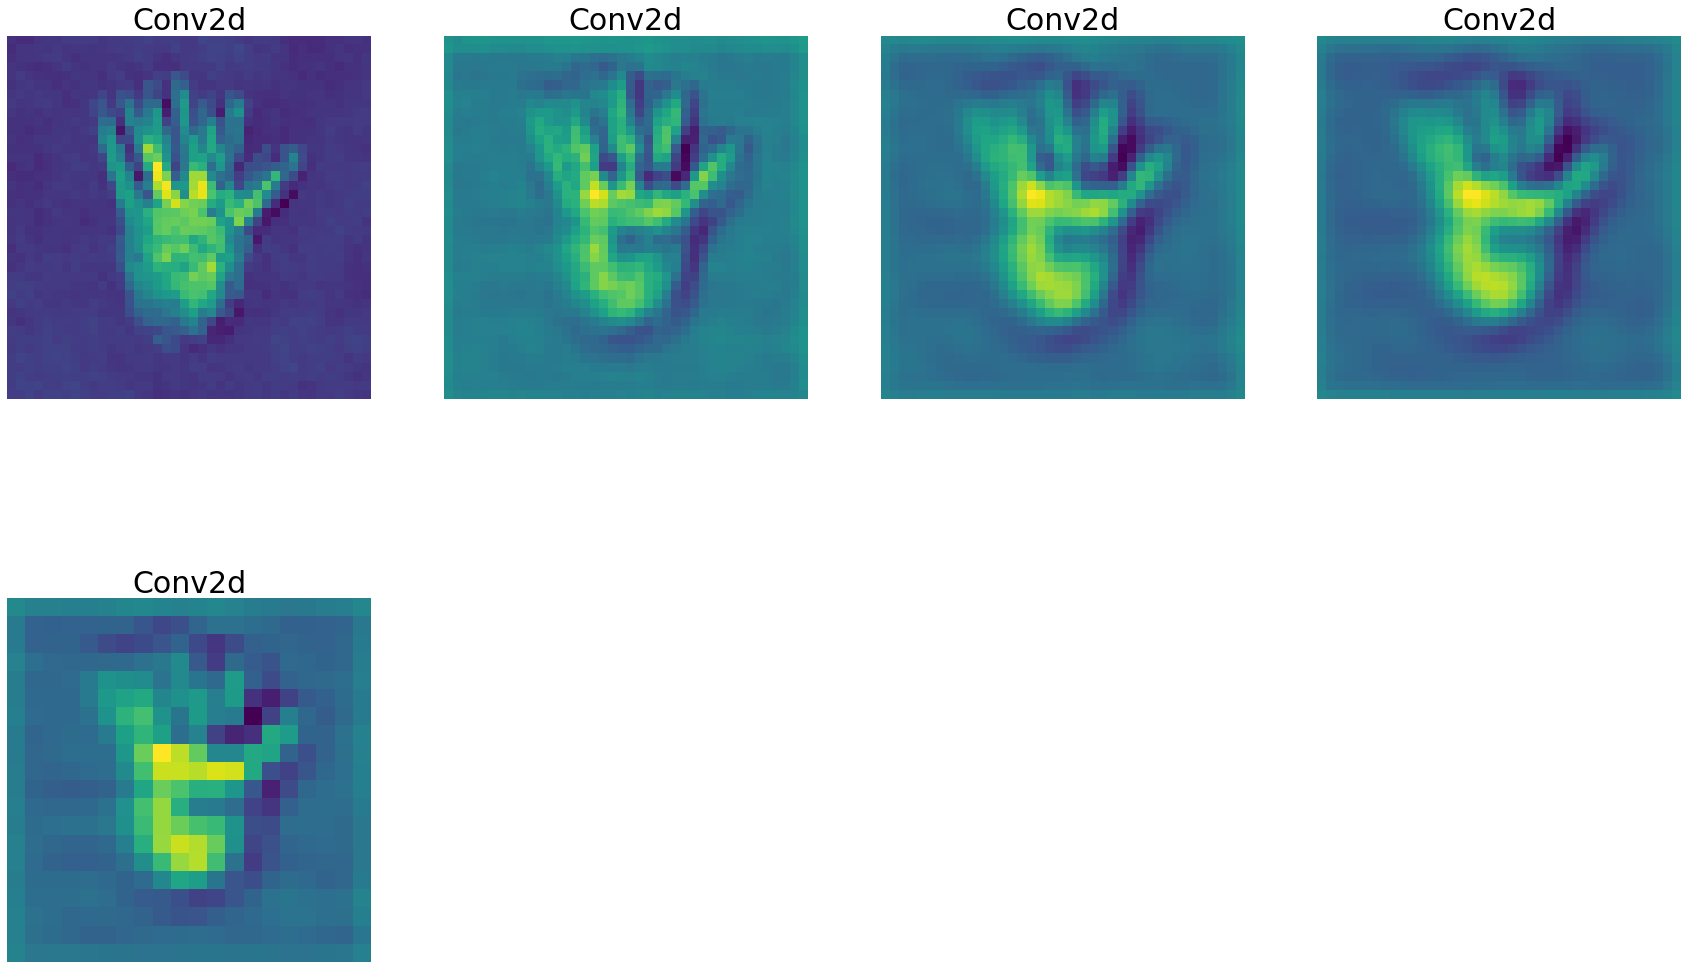

In [15]:
model.to('cpu')

# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

sequential_1 = list(model.children())[0]

for child in sequential_1:
    if type(child) == nn.Conv2d:
        counter+=1
        model_weights.append(child.weight)
        conv_layers.append(child)
print(f"Total convolution layers: {counter}")


def visua_random(file_path):
    img=random.choice(os.listdir(file_path))
    img=Image.open(file_path+img)
    plt.imshow(img)
    img=trf(img).unsqueeze(0)
    outputs = []    
    names=[]
    for layer in conv_layers:
        img = layer(img)
        outputs.append(img)
        names.append(str(layer))
    #print feature_maps    
          
    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale.data.cpu().numpy())
    fig = plt.figure(figsize=(30, 50))
    for i in range(len(processed)):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(processed[i])
        a.axis("off")
        a.set_title(names[i].split('(')[0], fontsize=30)
    pass 

visua_random('./test/')

In [30]:
torch.save(model,'batch_40_acurracy_99.pt')

|RUN|Optimizer| Batch size | lr | Weight decay | Best accuracy|Epoch|
|---|---|---|---|---|---|---|
|1  |Adam| 50 |0.00003| NA| 97%|5|
|2|Adam|72 |0.00002|1e-5|91%|6|
3|Adam|90|0.00002|1e-5|98%|7|
|4|RMSprop|40|0.00002|1e-6|99%|7|

|Layer| Dimension| Filter|Stride|Padding|
|---|---|---|---|---|
|Input|1x128x128|NA|NA|NA|
|Conv1|48x40x40|11x11|3|NA|
|Conv2|96x40x40|5x5|1|2|
|Maxp1|96x20x20|2x2|2|NA|
|Conv3|192x20x20|3x3|1|1|
|Maxp2|192x10x10|2x2|2|NA|
|Conv4|72x5x5|2x2|2|NA|
|FC1|1x5x5x72|NA|NA|NA|
|FC2|1x3x6x30|NA|NA|NA|
|FC3|1x3x4x8|NA|NA|NA|
|SftM|1x12|NA|NA|NA|

# Load Model

In [ ]:
import torchvision.transforms as T
import os
from PIL import Image
import matplotlib.pyplot  as plt
import torch
import random


model=torch.load('RMSprop_40_acurracy_99.pt')
model.eval()

trf = T.Compose([T.ToTensor(), 
             T.Normalize((0.5,),(0.5,))])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
